In [ ]:
!pip install torch-geometric



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.0 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

# Load the Cora dataset with threat likelihood as an additional label
dataset = Planetoid(root='./data', name='Cora', split='public')

# Add a 'threat_likelihood' attribute to each node and 'importance' attribute (you may need to replace these with your actual data)
# Here, we create random likelihood and importance values between 0 and 1 for each node.
import random
for data in dataset:
    data.threat_likelihood = torch.tensor([random.random() for _ in range(data.num_nodes)])
    data.importance = torch.tensor([random.random() for _ in range(data.num_nodes)])

# Define the GCN model to predict both class labels and threat likelihood
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNNet, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1), data.threat_likelihood

# Initialize the model and optimizer
model = GCNNet(dataset.num_features, 16, dataset.num_classes)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Define a custom importance-based loss function
def importance_loss(logits, importance, mask):
    predicted_importance = logits[mask]
    return F.mse_loss(predicted_importance, importance[mask])

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    logits, threat_likelihood = model(data)
    class_loss = F.nll_loss(logits[data.train_mask], data.y[data.train_mask])
    importance_loss_value = importance_loss(threat_likelihood, data.importance, data.train_mask)
    loss = class_loss + importance_loss_value
    loss.backward()
    optimizer.step()

# Testing loop
def test():
    model.eval()
    logits, _ = model(data)
    pred = logits.argmax(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / int(data.test_mask.sum())
    return acc

# Main training and testing loop
for epoch in range(200):
    train()
    test_acc = test()
    print(f'Epoch: {epoch + 1:03d}, Test Acc: {test_acc:.4f}')

# Output final test accuracy
print(f'Final Test Accuracy: {test_acc:.4f}')


Processing...
Done!


GCNNet(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)
Epoch: 001, Test Acc: 0.3420
Epoch: 002, Test Acc: 0.4210
Epoch: 003, Test Acc: 0.4730
Epoch: 004, Test Acc: 0.5010
Epoch: 005, Test Acc: 0.5330
Epoch: 006, Test Acc: 0.5540
Epoch: 007, Test Acc: 0.5650
Epoch: 008, Test Acc: 0.5880
Epoch: 009, Test Acc: 0.6000
Epoch: 010, Test Acc: 0.6410
Epoch: 011, Test Acc: 0.6760
Epoch: 012, Test Acc: 0.7040
Epoch: 013, Test Acc: 0.7320
Epoch: 014, Test Acc: 0.7510
Epoch: 015, Test Acc: 0.7620
Epoch: 016, Test Acc: 0.7700
Epoch: 017, Test Acc: 0.7740
Epoch: 018, Test Acc: 0.7790
Epoch: 019, Test Acc: 0.7870
Epoch: 020, Test Acc: 0.7930
Epoch: 021, Test Acc: 0.7940
Epoch: 022, Test Acc: 0.7910
Epoch: 023, Test Acc: 0.7940
Epoch: 024, Test Acc: 0.7900
Epoch: 025, Test Acc: 0.7940
Epoch: 026, Test Acc: 0.7920
Epoch: 027, Test Acc: 0.7900
Epoch: 028, Test Acc: 0.7870
Epoch: 029, Test Acc: 0.7870
Epoch: 030, Test Acc: 0.7820
Epoch: 031, Test Acc: 0.7790
Epoch: 032, Test Acc: 0.7780
Epoch: 

In [ ]:
def model_summary(model):
    print("Model Summary:")
    print("-" * 50)
    print(model)
    print("-" * 50)
    print("Trainable Parameters:")
    total_params = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.numel()}")
            total_params += param.numel()
    print("-" * 50)
    print(f"Total Trainable Parameters: {total_params}")

# Print the model summary
model_summary(model)


Model Summary:
--------------------------------------------------
GCNNet(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)
--------------------------------------------------
Trainable Parameters:
conv1.bias: 16
conv1.lin.weight: 22928
conv2.bias: 7
conv2.lin.weight: 112
--------------------------------------------------
Total Trainable Parameters: 23063


In [ ]:
from graphviz import Digraph

# Create a directed graph
flowchart = Digraph('CodeFlow', format='png')

# Define nodes
nodes = [
    'Load Dataset',
    'Define GCN Model',
    'Model Training Setup',
    'Model Evaluation Setup',
    'Main Training Loop',
    'Output Final Test Accuracy'
]

# Add nodes to the graph
for node in nodes:
    flowchart.node(node)

# Define edges (code flow)
edges = [
    ('Load Dataset', 'Define GCN Model'),
    ('Define GCN Model', 'Model Training Setup'),
    ('Model Training Setup', 'Model Evaluation Setup'),
    ('Model Evaluation Setup', 'Main Training Loop'),
    ('Main Training Loop', 'Output Final Test Accuracy')
]

# Add edges to the graph
for edge in edges:
    flowchart.edge(*edge)

# Save and render the flowchart
flowchart.render('code_flow', view=True)


'code_flow.png'

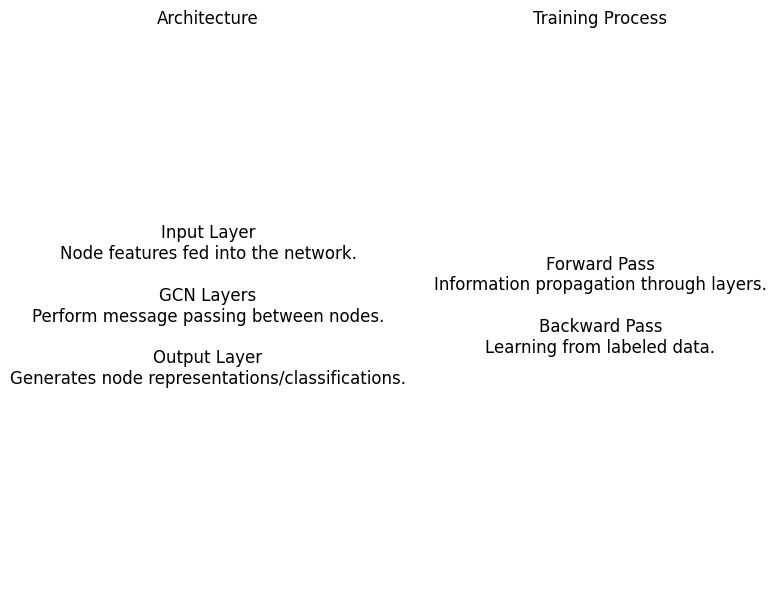

In [ ]:
import matplotlib.pyplot as plt

# Create a flowchart-style diagram for architecture and training process
plt.figure(figsize=(8, 6))

# Architecture
plt.subplot(1, 2, 1)
plt.title('Architecture')
arch_text = ("Input Layer\nNode features fed into the network.\n\n"
             "GCN Layers\nPerform message passing between nodes.\n\n"
             "Output Layer\nGenerates node representations/classifications.")
plt.text(0.5, 0.5, arch_text, ha='center', va='center', fontsize=12)
plt.axis('off')

# Training Process
plt.subplot(1, 2, 2)
plt.title('Training Process')
train_text = ("Forward Pass\nInformation propagation through layers.\n\n"
              "Backward Pass\nLearning from labeled data.")
plt.text(0.5, 0.5, train_text, ha='center', va='center', fontsize=12)
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Print a basic flowchart-style representation

print("      [Start]")
print("         |")
print("         |")
print(" Load Cora dataset")
print("         |")
print("         |")
print(" Initialize GCN model")
print("         |")
print("         |")
print(" Training Loop (for each epoch)")
print("   |-------------------|")
print("   |                   |")
print(" Model training    Testing Loop")
print("   |                   |")
print("   |-------------------|")
print("         |")
print("         |")
print(" [Output final test accuracy]")
print("         |")
print("         |")
print("      [End]")


      [Start]
         |
         |
 Load Cora dataset
         |
         |
 Initialize GCN model
         |
         |
 Training Loop (for each epoch)
   |-------------------|
   |                   |
 Model training    Testing Loop
   |                   |
   |-------------------|
         |
         |
 [Output final test accuracy]
         |
         |
      [End]


In [ ]:
print("   +-------------------------------+")
print("   |          [Start]              |")
print("   +---------------+---------------+")
print("                   |")
print("                   v")
print("   +-------------------------------+")
print("   | Load Cora dataset             |")
print("   +---------------+---------------+")
print("                   |")
print("                   v")
print("   +--------------------------------------------------+")
print("   | Initialize GCN model                             |")
print("   |  - Node features fed into the network            |")
print("   |  - Perform message passing between nodes         |")
print("   |  - Generates node representations/classifications|")
print("   +---------------+---------------+")
print("                   |")
print("                   v")
print("   +-------------------------------+")
print("   | Training Loop (for each epoch)|")
print("   +---------------+---------------+")
print("                   |")
print("                   v")
print("   +-------------------------------+")
print("   | Model training                |")
print("   +-------------------------------+")
print("                   |")
print("                   v")
print("   +-------------------------------+")
print("   | Testing Loop                  |")
print("   +---------------+---------------+")
print("                   |")
print("                   v")
print("   +-------------------------------+")
print("   | Model Evaluation              |")
print("   +---------------+---------------+")
print("                   |")
print("                   v")
print("   +-------------------------------+")
print("   | Output final test accuracy    |")
print("   +---------------+---------------+")
print("                   |")
print("                   v")
print("   +-------------------------------+")
print("   |             [End]              |")
print("   +-------------------------------+")


   +-------------------------------+
   |          [Start]              |
   +---------------+---------------+
                   |
                   v
   +-------------------------------+
   | Load Cora dataset             |
   +---------------+---------------+
                   |
                   v
   +-------------------------------+
   | Initialize GCN model          |
   |  - Node features fed into the network|
   |  - Perform message passing between nodes|
   |  - Generates node representations/classifications|
   +---------------+---------------+
                   |
                   v
   +-------------------------------+
   | Training Loop (for each epoch)|
   +---------------+---------------+
                   |
                   v
   +-------------------------------+
   | Model training                |
   +-------------------------------+
                   |
                   v
   +-------------------------------+
   | Testing Loop                  |
   +----------

In [ ]:
print("   +-------------------------------+")
print("   |          [Start]              |")
print("   +---------------+---------------+")
print("                   |")
print("                   v")
print("   +-------------------------------+")
print("   | Load Cora dataset             |")
print("   +---------------+---------------+")
print("                   |")
print("                   v")
print("   +--------------------------------------------------+")
print("   | Initialize GCN model                             |")
print("   |  - Define graph convolutional layers (GCN Layers)|")
print("   |  - Each layer processes node features and        |")
print("   |    aggregates information from neighboring nodes |")
print("   |  - Apply non-linear transformations to generate  |")
print("   |    node representations/classifications          |")
print("   +--------------------------------------------------+")
print("                   |")
print("                   v")
print("   +-------------------------------+")
print("   | Training Loop (for each epoch)|")
print("   +---------------+---------------+")
print("                   |")
print("                   v")
print("   +-------------------------------+")
print("   | Model Training (GCN Layers)  |")
print("   +-------------------------------+")
print("                   |")
print("                   v")
print("   +-------------------------------+")
print("   | Testing Loop                  |")
print("   +---------------+---------------+")
print("                   |")
print("                   v")
print("   +-------------------------------+")
print("   | Output final test accuracy    |")
print("   +---------------+---------------+")
print("                   |")
print("                   v")
print("   +-------------------------------+")
print("   |             [End]              |")
print("   +-------------------------------+")


   +-------------------------------+
   |          [Start]              |
   +---------------+---------------+
                   |
                   v
   +-------------------------------+
   | Load Cora dataset             |
   +---------------+---------------+
                   |
                   v
   +--------------------------------------------------+
   | Initialize GCN model                             |
   |  - Define graph convolutional layers (GCN Layers)|
   |  - Each layer processes node features and        |
   |    aggregates information from neighboring nodes |
   |  - Apply non-linear transformations to generate  |
   |    node representations/classifications          |
   +--------------------------------------------------+
                   |
                   v
   +-------------------------------+
   | Training Loop (for each epoch)|
   +---------------+---------------+
                   |
                   v
   +-------------------------------+
   | Model Tra

In [ ]:
import pandas as pd

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

# Load the Cora dataset with threat likelihood as an additional label
dataset = Planetoid(root='./data', name='Cora', split='public')

# Add a 'threat_likelihood' attribute to each node and 'importance' attribute
import random
for data in dataset:
    data.threat_likelihood = torch.tensor([random.random() for _ in range(data.num_nodes)])
    data.importance = torch.tensor([random.random() for _ in range(data.num_nodes)])

# Define the GCN model to predict both class labels and threat likelihood
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNNet, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1), data.threat_likelihood

# Initialize the model and optimizer
model = GCNNet(dataset.num_features, 16, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Define a custom importance-based loss function
def importance_loss(logits, importance, mask):
    predicted_importance = logits[mask]
    return F.mse_loss(predicted_importance, importance[mask])

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    logits, threat_likelihood = model(data)
    class_loss = F.nll_loss(logits[data.train_mask], data.y[data.train_mask])
    importance_loss_value = importance_loss(threat_likelihood, data.importance, data.train_mask)
    loss = class_loss + importance_loss_value
    loss.backward()
    optimizer.step()

# Testing loop
def test():
    model.eval()
    logits, _ = model(data)
    pred = logits.argmax(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / int(data.test_mask.sum())
    return acc

# Main training and testing loop
for epoch in range(200):
    train()
    test_acc = test()
    print(f'Epoch: {epoch + 1:03d}, Test Acc: {test_acc:.4f}')

# Output final test accuracy
print(f'Final Test Accuracy: {test_acc:.4f}')

# Find and print the top 10 nodes with the highest combined importance and threat likelihood
combined_scores = data.importance + data.threat_likelihood
top_10_nodes = combined_scores.argsort(descending=True)[:10]
print("Top 10 Nodes:")
for node_idx in top_10_nodes:
    print(f"Node {node_idx}: Importance = {data.importance[node_idx]:.4f}, Threat Likelihood = {data.threat_likelihood[node_idx]:.4f}")


Epoch: 001, Test Acc: 0.5810
Epoch: 002, Test Acc: 0.6370
Epoch: 003, Test Acc: 0.6390
Epoch: 004, Test Acc: 0.6420
Epoch: 005, Test Acc: 0.6440
Epoch: 006, Test Acc: 0.6560
Epoch: 007, Test Acc: 0.6870
Epoch: 008, Test Acc: 0.6960
Epoch: 009, Test Acc: 0.7200
Epoch: 010, Test Acc: 0.7350
Epoch: 011, Test Acc: 0.7480
Epoch: 012, Test Acc: 0.7610
Epoch: 013, Test Acc: 0.7680
Epoch: 014, Test Acc: 0.7730
Epoch: 015, Test Acc: 0.7770
Epoch: 016, Test Acc: 0.7780
Epoch: 017, Test Acc: 0.7790
Epoch: 018, Test Acc: 0.7810
Epoch: 019, Test Acc: 0.7810
Epoch: 020, Test Acc: 0.7830
Epoch: 021, Test Acc: 0.7820
Epoch: 022, Test Acc: 0.7810
Epoch: 023, Test Acc: 0.7800
Epoch: 024, Test Acc: 0.7810
Epoch: 025, Test Acc: 0.7800
Epoch: 026, Test Acc: 0.7790
Epoch: 027, Test Acc: 0.7780
Epoch: 028, Test Acc: 0.7800
Epoch: 029, Test Acc: 0.7790
Epoch: 030, Test Acc: 0.7790
Epoch: 031, Test Acc: 0.7780
Epoch: 032, Test Acc: 0.7790
Epoch: 033, Test Acc: 0.7810
Epoch: 034, Test Acc: 0.7820
Epoch: 035, Te

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

# Load the Cora dataset with threat likelihood as an additional label
dataset = Planetoid(root='./data', name='Cora', split='public')

# Add a 'threat_likelihood' attribute to each node and 'importance' attribute
import random
for data in dataset:
    data.threat_likelihood = torch.tensor([random.random() for _ in range(data.num_nodes)])
    data.importance = torch.tensor([random.random() for _ in range(data.num_nodes)])

# Define the GCN model to predict both class labels and threat likelihood
class GCNNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNNet, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1), data.threat_likelihood

# Initialize the model and optimizer
model = GCNNet(dataset.num_features, 16, dataset.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Define a custom importance-based loss function
def importance_loss(logits, importance, mask):
    predicted_importance = logits[mask]
    return F.mse_loss(predicted_importance, importance[mask])

# Training loop
def train():
    model.train()
    optimizer.zero_grad()
    logits, threat_likelihood = model(data)
    class_loss = F.nll_loss(logits[data.train_mask], data.y[data.train_mask])
    importance_loss_value = importance_loss(threat_likelihood, data.importance, data.train_mask)
    loss = class_loss + importance_loss_value
    loss.backward()
    optimizer.step()

# Testing loop
def test():
    model.eval()
    logits, _ = model(data)
    pred = logits.argmax(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    acc = correct / int(data.test_mask.sum())
    return acc

# Main training and testing loop
for epoch in range(200):
    train()
    test_acc = test()
    print(f'Epoch: {epoch + 1:03d}, Test Acc: {test_acc:.4f}')

# Output final test accuracy
print(f'Final Test Accuracy: {test_acc:.4f}')

# Find and print the bottom 10 nodes with the lowest combined importance and threat likelihood
combined_scores = data.importance + data.threat_likelihood
bottom_10_nodes = combined_scores.argsort()[:10]
print("Bottom 10 Nodes:")
for node_idx in bottom_10_nodes:
    print(f"Node {node_idx}: Importance = {data.importance[node_idx]:.4f}, Threat Likelihood = {data.threat_likelihood[node_idx]:.4f}")


Epoch: 001, Test Acc: 0.2580
Epoch: 002, Test Acc: 0.3430
Epoch: 003, Test Acc: 0.3980
Epoch: 004, Test Acc: 0.4590
Epoch: 005, Test Acc: 0.6000
Epoch: 006, Test Acc: 0.6820
Epoch: 007, Test Acc: 0.7330
Epoch: 008, Test Acc: 0.7560
Epoch: 009, Test Acc: 0.7730
Epoch: 010, Test Acc: 0.7810
Epoch: 011, Test Acc: 0.7850
Epoch: 012, Test Acc: 0.7860
Epoch: 013, Test Acc: 0.7870
Epoch: 014, Test Acc: 0.7850
Epoch: 015, Test Acc: 0.7840
Epoch: 016, Test Acc: 0.7840
Epoch: 017, Test Acc: 0.7840
Epoch: 018, Test Acc: 0.7850
Epoch: 019, Test Acc: 0.7820
Epoch: 020, Test Acc: 0.7830
Epoch: 021, Test Acc: 0.7810
Epoch: 022, Test Acc: 0.7790
Epoch: 023, Test Acc: 0.7770
Epoch: 024, Test Acc: 0.7760
Epoch: 025, Test Acc: 0.7780
Epoch: 026, Test Acc: 0.7780
Epoch: 027, Test Acc: 0.7760
Epoch: 028, Test Acc: 0.7750
Epoch: 029, Test Acc: 0.7760
Epoch: 030, Test Acc: 0.7750
Epoch: 031, Test Acc: 0.7730
Epoch: 032, Test Acc: 0.7740
Epoch: 033, Test Acc: 0.7760
Epoch: 034, Test Acc: 0.7770
Epoch: 035, Te

In [ ]:
!pip install dgl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 13.7 MB/s eta 0:00:00


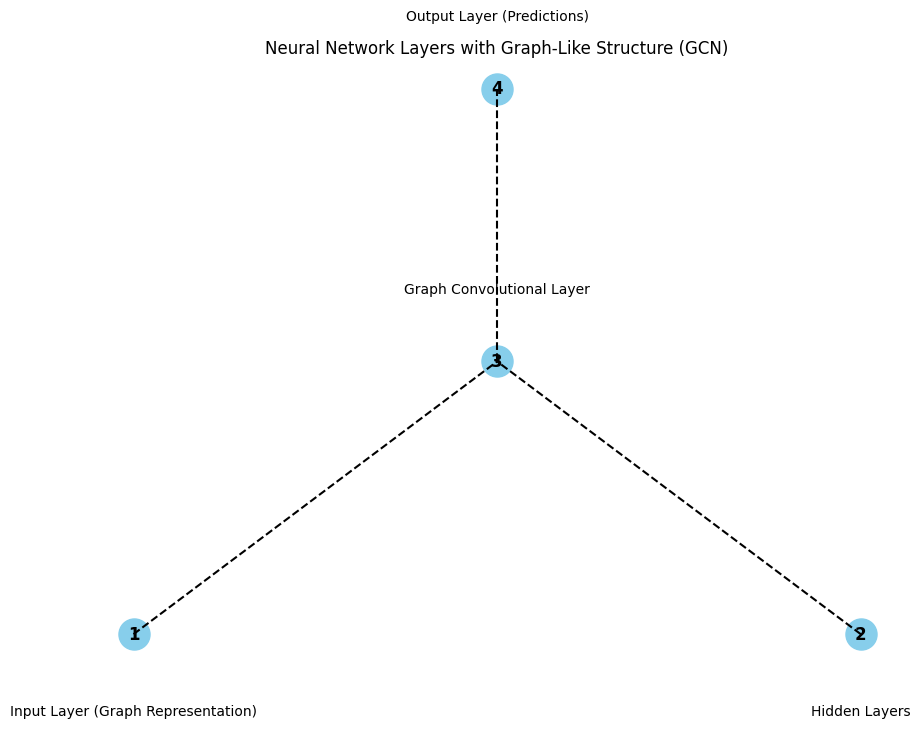

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a graph structure
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4])  # Nodes representing data

# Define the layout for better visualization
pos = {1: (0, 0), 2: (1, 0), 3: (0.5, 1), 4: (0.5, 2)}

# Plot neural network layers and graph structure
plt.figure(figsize=(8, 6))

# Draw edges and nodes to represent the graph-like structure
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, font_weight='bold', font_size=12)

# Neural Network Layers Representation
plt.text(0, -0.3, 'Input Layer (Graph Representation)', fontsize=10, ha='center')
plt.text(1, -0.3, 'Hidden Layers', fontsize=10, ha='center')
plt.text(0.5, 1.25, 'Graph Convolutional Layer', fontsize=10, ha='center')
plt.text(0.5, 2.25, 'Output Layer (Predictions)', fontsize=10, ha='center')

# Connections between graph nodes and neural network layers
plt.plot([0, 0.5], [0, 1], linestyle='--', color='black')
plt.plot([1, 0.5], [0, 1], linestyle='--', color='black')
plt.plot([0.5, 0.5], [1, 2], linestyle='--', color='black')

# Set plot properties
plt.title('Neural Network Layers with Graph-Like Structure (GCN)')
plt.axis('off')

plt.show()



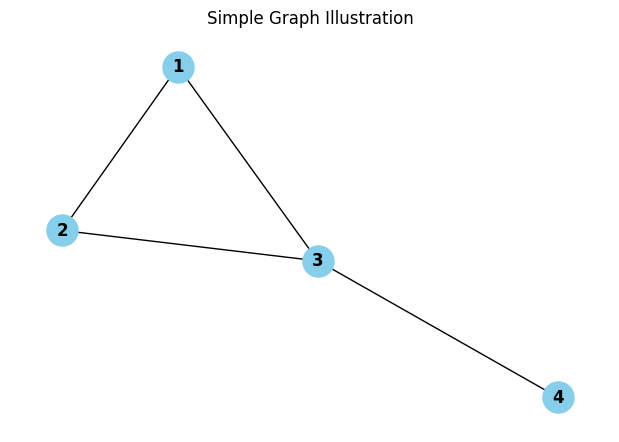

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a simple graph
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4])  # Adding nodes
G.add_edges_from([(1, 2), (1, 3), (2, 3), (3, 4)])  # Adding edges

# Plot the graph
plt.figure(figsize=(6, 4))
pos = nx.spring_layout(G)  # Layout for better visualization
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=500, font_weight='bold', font_size=12)
plt.title('Simple Graph Illustration')
plt.show()


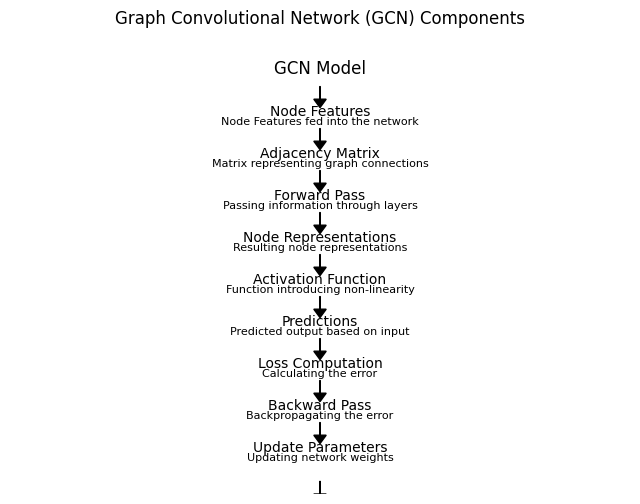

In [ ]:
import matplotlib.pyplot as plt

# Create a flowchart-style diagram for GCN components with detailed annotations
plt.figure(figsize=(8, 6))

# GCN Components with details
plt.subplot(1, 1, 1)
plt.title('Graph Convolutional Network (GCN) Components')

# Annotated components
plt.text(0.5, 0.9, "GCN Model", fontsize=12, ha='center')
plt.text(0.5, 0.8, "Node Features", fontsize=10, ha='center')
plt.text(0.5, 0.7, "Adjacency Matrix", fontsize=10, ha='center')
plt.text(0.5, 0.6, "Forward Pass", fontsize=10, ha='center')
plt.text(0.5, 0.5, "Node Representations", fontsize=10, ha='center')
plt.text(0.5, 0.4, "Activation Function", fontsize=10, ha='center')
plt.text(0.5, 0.3, "Predictions", fontsize=10, ha='center')
plt.text(0.5, 0.2, "Loss Computation", fontsize=10, ha='center')
plt.text(0.5, 0.1, "Backward Pass", fontsize=10, ha='center')
plt.text(0.5, 0, "Update Parameters", fontsize=10, ha='center')

# Annotations explaining each step
plt.text(0.5, 0.78, "Node Features fed into the network", fontsize=8, ha='center')
plt.text(0.5, 0.68, "Matrix representing graph connections", fontsize=8, ha='center')
plt.text(0.5, 0.58, "Passing information through layers", fontsize=8, ha='center')
plt.text(0.5, 0.48, "Resulting node representations", fontsize=8, ha='center')
plt.text(0.5, 0.38, "Function introducing non-linearity", fontsize=8, ha='center')
plt.text(0.5, 0.28, "Predicted output based on input", fontsize=8, ha='center')
plt.text(0.5, 0.18, "Calculating the error", fontsize=8, ha='center')
plt.text(0.5, 0.08, "Backpropagating the error", fontsize=8, ha='center')
plt.text(0.5, -0.02, "Updating network weights", fontsize=8, ha='center')

# Arrows representing the flow of operations
for y_coord in [0.87, 0.77, 0.67, 0.57, 0.47, 0.37, 0.27, 0.17, 0.07, -0.07]:
    plt.arrow(0.5, y_coord, 0, -0.03, head_width=0.02, head_length=0.02, fc='black', ec='black')

# Set plot properties
plt.xlim(0, 1)
plt.ylim(-0.1, 1)
plt.axis('off')

plt.show()


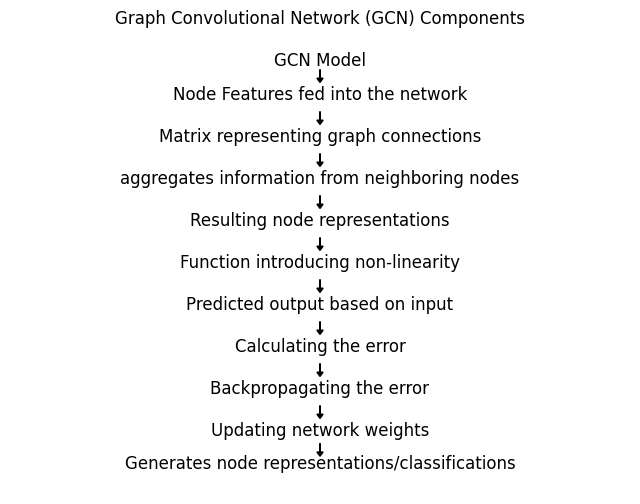

In [ ]:
import matplotlib.pyplot as plt

# Create a flowchart-style diagram for GCN components with detailed annotations
plt.figure(figsize=(8, 6))

# GCN Components with details
plt.subplot(1, 1, 1)
plt.title('Graph Convolutional Network (GCN) Components')

# # Annotated components
plt.text(0.5, 0.92, "GCN Model", fontsize=12, ha='center')
# plt.text(0.5, 0.82, "Node Features", fontsize=10, ha='center')
# plt.text(0.5, 0.72, "Adjacency Matrix", fontsize=10, ha='center')
# plt.text(0.5, 0.62, "(aggregates information from neighboring nodes)", fontsize=10, ha='center')
# plt.text(0.5, 0.52, "Node Representations", fontsize=10, ha='center')
# plt.text(0.5, 0.42, "Activation Function", fontsize=10, ha='center')
# plt.text(0.5, 0.32, "Predictions", fontsize=10, ha='center')
# plt.text(0.5, 0.22, "Loss Computation", fontsize=10, ha='center')
# plt.text(0.5, 0.12, "Backward Pass", fontsize=10, ha='center')
# plt.text(0.5, 0.02, "Update Parameters", fontsize=10, ha='center')

# Annotations explaining each step
plt.text(0.5, 0.84, "Node Features fed into the network", fontsize=12, ha='center')
plt.text(0.5, 0.74, "Matrix representing graph connections", fontsize=12, ha='center')
plt.text(0.5, 0.64, "aggregates information from neighboring nodes", fontsize=12, ha='center')
plt.text(0.5, 0.54, "Resulting node representations", fontsize=12, ha='center')
plt.text(0.5, 0.44, "Function introducing non-linearity", fontsize=12, ha='center')
plt.text(0.5, 0.34, "Predicted output based on input", fontsize=12, ha='center')
plt.text(0.5, 0.24, "Calculating the error", fontsize=12, ha='center')
plt.text(0.5, 0.14, "Backpropagating the error", fontsize=12, ha='center')
plt.text(0.5, 0.04, "Updating network weights", fontsize=12, ha='center')
plt.text(0.5, -0.04, "Generates node representations/classifications", fontsize=12, ha='center')


# Arrows representing the flow of operations
for y_coord in [0.91, 0.81, 0.71, 0.61, 0.51, 0.41, 0.31, 0.21, 0.11,0.02]:
    plt.arrow(0.5, y_coord, 0, -0.02, head_width=0.01, head_length=0.01, fc='black', ec='black')

# Set plot properties
plt.xlim(0, 1)
plt.ylim(-0.1, 1)
plt.axis('off')

plt.show()
